In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import cv2
import os
import glob
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adadelta, Adam
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, History
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from __future__ import division, print_function
from collections import Counter
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# for fish_class in glob.glob('data/train/*'): os.mkdir('data/final_valid/' + fish_class.split('/')[2])

# rnd_ord = np.random.permutation(glob.glob('data/final_train/*/*.jpg'))
# for i in range(800): os.rename(rnd_ord[i], 'data/final_valid/' + rnd_ord[i].split('/')[2]+'/'+rnd_ord[i].split('/')[3])

In [2]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def VGG_16(size=(224, 224), weights_path='data/vgg16_bn_conv.txt'):
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,)+size))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))


    if weights_path:
        model.load_weights(weights_path)

    return model


In [14]:
size = (360,360)
model = VGG_16(size=size)


for layer in model.layers:
    layer.trainable = False

model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 360, 360)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [15]:
nb_train_samples = len(glob.glob('data/train_org_re/*/*.jpg'))
nb_validation_samples = len(glob.glob('data/final_valid/*/*.jpg'))
nb_epoch = 2
bath_size = 16

classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

train_datagen = ImageDataGenerator(
        shear_range=0.3,
        zoom_range=0.1,
        rotation_range=40.,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'data/train_org_re/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
        'data/final_valid/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')


model.compile(Adam(lr=0.01), loss='categorical_crossentropy', \
              metrics=["accuracy"])

# fine-tune the model
hist = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

# model.compile(Adam(lr=0.001), loss='categorical_crossentropy', \
#               metrics=["accuracy"])

# # fine-tune the model
# hist = model.fit_generator(
#         train_generator,
#         samples_per_epoch=nb_train_samples,
#         nb_epoch=5,
#         validation_data=validation_generator,
#         nb_val_samples=nb_validation_samples)

Found 3777 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Epoch 1/3
3777/3777 [==============================] - 277s - loss: 2.0784 - acc: 0.4453 - val_loss: 2.7397 - val_acc: 0.3675

In [22]:
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', \
              metrics=["accuracy"])

model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=3,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/3
3777/3777 [==============================] - 277s - loss: 0.6997 - acc: 0.7535 - val_loss: 1.5179 - val_acc: 0.5837

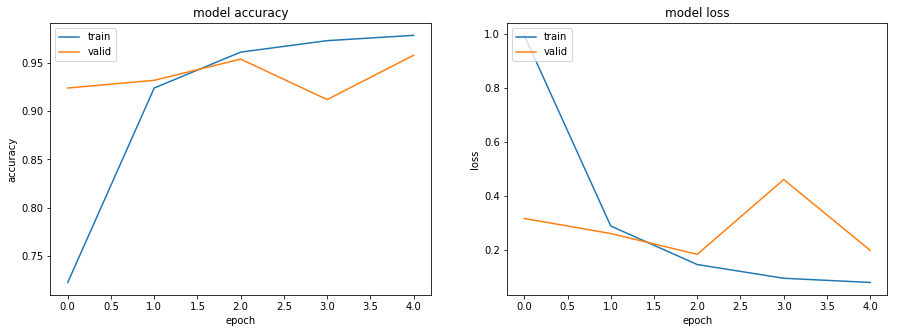

In [6]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [34]:
model.save_weights('final_fast_vgg_1.pkl')

In [9]:
# Augmentation

nb_test_samples = len(glob.glob('data/test/*/*.jpg'))
nb_test_samples2 = len(glob.glob('data/test2/*/*.jpg'))
test_aug = 10
test_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

for aug in range(test_aug):
    print('Predictions for Augmented -', aug)
    random_seed = np.random.random_integers(0, 100000)

    test_generator = test_datagen.flow_from_directory(
            'data/test/',
            target_size=size,
            batch_size=16,
            shuffle = False,
            classes = None,
            class_mode = None)

    test_image_list = test_generator.filenames
    if aug == 0:
        predictions = model.predict_generator(test_generator, nb_test_samples)
    else:
        predictions += model.predict_generator(test_generator, nb_test_samples)
        
    test_generator2 = test_datagen.flow_from_directory(
            'data/test2/',
            target_size=size,
            batch_size=16,
            shuffle = False,
            classes = None,
            class_mode = None)

    test_image_list2 = test_generator2.filenames
    if aug == 0:
        predictions2 = model.predict_generator(test_generator2, nb_test_samples2)
    else:
        predictions2 += model.predict_generator(test_generator2, nb_test_samples2)

        
    
predictions /= test_aug
predictions2 /= test_aug

Predictions for Augmented - 0
Found 1000 images belonging to 1 classes.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead


Found 12153 images belonging to 1 classes.
Predictions for Augmented - 1
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 2
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 3
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 4
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 5
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 6
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 7
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 8
Found 1000 images belonging to 1 classes.
Found 12153 images belonging to 1 classes.
Predictions for Augmented - 9
Found 1

In [36]:
# clip predictions
c = 0
preds = np.clip(predictions, c, 1-c)

print('Begin to write submission file ..')
f_submit = open('submit_12.csv', 'w')
f_submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
for i, image_name in enumerate(test_generator.filenames):
    pred = ['%.6f' % p for p in preds[i, :]]
    if i%100 == 0:
        print(i, '/', 1000)
    f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

preds2 = np.clip(predictions2, c, 1-c)
for i, image_name in enumerate(test_generator2.filenames):
    pred2 = ['%.6f' % p for p in preds2[i, :]]
    if i%100 == 0:
        print(i, '/', 1000)
    f_submit.write('%s,%s\n' % ('test_stg2/'+os.path.basename(image_name), ','.join(pred2)))
    
f_submit.close()

Begin to write submission file ..
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
1100 / 1000
1200 / 1000
1300 / 1000
1400 / 1000
1500 / 1000
1600 / 1000
1700 / 1000
1800 / 1000
1900 / 1000
2000 / 1000
2100 / 1000
2200 / 1000
2300 / 1000
2400 / 1000
2500 / 1000
2600 / 1000
2700 / 1000
2800 / 1000
2900 / 1000
3000 / 1000
3100 / 1000
3200 / 1000
3300 / 1000
3400 / 1000
3500 / 1000
3600 / 1000
3700 / 1000
3800 / 1000
3900 / 1000
4000 / 1000
4100 / 1000
4200 / 1000
4300 / 1000
4400 / 1000
4500 / 1000
4600 / 1000
4700 / 1000
4800 / 1000
4900 / 1000
5000 / 1000
5100 / 1000
5200 / 1000
5300 / 1000
5400 / 1000
5500 / 1000
5600 / 1000
5700 / 1000
5800 / 1000
5900 / 1000
6000 / 1000
6100 / 1000
6200 / 1000
6300 / 1000
6400 / 1000
6500 / 1000
6600 / 1000
6700 / 1000
6800 / 1000
6900 / 1000
7000 / 1000
7100 / 1000
7200 /

In [35]:
nb_test_samples = len(glob.glob('data/cropped_nof_excl/*/*.jpg'))

test_aug = 10
test_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

for aug in range(test_aug):
    print('Predictions for Augmented -', aug)
    random_seed = np.random.random_integers(0, 100000)

    test_generator = test_datagen.flow_from_directory(
            'data/cropped_nof_excl/',
            target_size=size,
            batch_size=16,
            shuffle = False,
            classes = None,
            class_mode = None)

    test_image_list = test_generator.filenames
    if aug == 0:
        predictions = model.predict_generator(test_generator, nb_test_samples)
    else:
        predictions += model.predict_generator(test_generator, nb_test_samples)
        
predictions /= test_aug

Predictions for Augmented - 0
Found 1000 images belonging to 1 classes.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead


Predictions for Augmented - 1
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 2
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 3
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 4
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 5
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 6
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 7
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 8
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 9
Found 1000 images belonging to 1 classes.
